In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
%cd /content/drive/MyDrive/youtube_tutorial
#!unzip test.csv.zip
#!unzip train.csv.zip

/content/drive/MyDrive/youtube_tutorial
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [7]:
 import torch
 from torch import nn
 import pandas as pd
 from torch import optim
 from torch.utils.data import DataLoader, Dataset
 from torchvision import transforms
 from sklearn.model_selection import train_test_split
 import matplotlib.pyplot as plt
 import numpy as np
 import random
 import timeit
 from tqdm import tqdm

In [58]:
RANDOM_SEED=42
BATCH_SIZE=512
EPOCHS=40
#Classification from learnable token
LEARNING_RATE=1e-4
NUM_CLASS=10
PATCH_SIZE=4 # One size of a length of square size (4*4), like a respective field in CNN
IMAGE_SIZE=28 #Image is 28*28
IN_CHANNELS=1
NUM_HEADS=8
DROPOUT=0.001
HIDDEN_DIM=768
ADAM_WEIGHT_DECAY=0
ADAM_BETAS=(0.9,0.999)
ACTIVATION="gelu"
NUM_ENCODERS=4 #Stack 4 different encoder
EMBED_DIM=(PATCH_SIZE**2)*IN_CHANNELS #16
NUM_PATCHES=(IMAGE_SIZE//PATCH_SIZE)**2 #49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

device = "cuda" if torch.cuda.is_available() else "cpu"


In [59]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        #Init x=(512,1,28,28)
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, #1
                out_channels=embed_dim, #16
                kernel_size=patch_size, #4
                stride=patch_size, #4
            ),
            #As stride=4, the shape become (512,16,7,7)
            nn.Flatten(2))
            # Keep the first 2 dimension of the data, then concat all of them after it
            #(512,16,7*7)

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True) #Classification token, learnable token
        #CLS stands for Classification token, torch.randn creates a tensor filled with random number (normal distribution with mean=0, sd=1), required_grad=True,
        #indicate it is a part of gradient descent
        #size (1 (Indicate it is a single classification tasks), in_channels (Indicate the image is grayscale), embed_dim stands for the input token)

        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        #size=(1(Indicate it is a single classification tasks, number of total patches+1, number of input embedding ))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) #Classification token

        x = self.patcher(x).permute(0, 2, 1)
        #x (512,49,16)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device) #(Batch size, number of Channel, Image dimension x, Image dimension y)
print(model(x).shape)

torch.Size([512, 50, 16])


In [60]:
class ViT(nn.Module):
  def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
    super().__init__()
    self.embeddings_block=PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

    encoder_layer=nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
    self.encoder_block=nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

    self.mlp_head=nn.Sequential(
        nn.LayerNorm(normalized_shape=embed_dim),
        nn.Linear(in_features=embed_dim, out_features=num_classes)

    )

  def forward(self,x):
    x=self.embeddings_block(x)
    x=self.encoder_block(x)
    x=self.mlp_head(x[:,0,:])
    return x

model=ViT(NUM_PATCHES, IMAGE_SIZE, NUM_CLASS, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)

#x=torch.randn(512,1,28,28).to(device)
#print(model(x).shape)



torch.Size([512, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [50]:
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv('test.csv')
submission_df=pd.read_csv('sample_submission.csv')

In [51]:
 train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [52]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [63]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

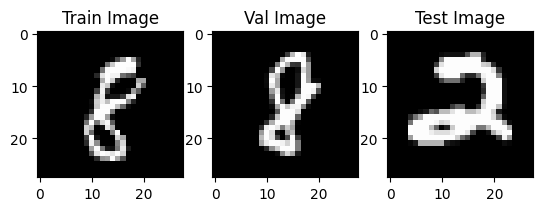

In [64]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [67]:
train_dataloader= DataLoader(dataset=train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True)
val_dataloader=DataLoader(dataset=val_dataset,
             batch_size=BATCH_SIZE,
             shuffle=True)
test_dataloader=DataLoader(dataset=test_dataset,
             batch_size=BATCH_SIZE,
             shuffle=True)

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:00<00:00,  9.56it/s]


------------------------------
Train Loss EPOCH 1: 1.8030
Valid Loss EPOCH 1: 1.6184


  2%|▎         | 1/40 [00:23<14:57, 23.02s/it]

Train Accuracy EPOCH 1: 0.3675
Valid Accuracy EPOCH 1: 0.4519
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.27it/s]


------------------------------
Train Loss EPOCH 2: 1.6019
Valid Loss EPOCH 2: 1.4451


  5%|▌         | 2/40 [00:45<14:29, 22.89s/it]

Train Accuracy EPOCH 2: 0.4636
Valid Accuracy EPOCH 2: 0.5379
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.70it/s]


------------------------------
Train Loss EPOCH 3: 1.4645
Valid Loss EPOCH 3: 1.3137


  8%|▊         | 3/40 [01:08<14:11, 23.00s/it]

Train Accuracy EPOCH 3: 0.5332
Valid Accuracy EPOCH 3: 0.6283
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.26it/s]


------------------------------
Train Loss EPOCH 4: 1.3363
Valid Loss EPOCH 4: 1.1864


 10%|█         | 4/40 [01:32<13:49, 23.03s/it]

Train Accuracy EPOCH 4: 0.5983
Valid Accuracy EPOCH 4: 0.6536
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.69it/s]


------------------------------
Train Loss EPOCH 5: 1.2287
Valid Loss EPOCH 5: 1.0788


 12%|█▎        | 5/40 [01:55<13:29, 23.14s/it]

Train Accuracy EPOCH 5: 0.6486
Valid Accuracy EPOCH 5: 0.7233
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.64it/s]


------------------------------
Train Loss EPOCH 6: 1.1334
Valid Loss EPOCH 6: 0.9861


 15%|█▌        | 6/40 [02:18<13:09, 23.23s/it]

Train Accuracy EPOCH 6: 0.6849
Valid Accuracy EPOCH 6: 0.7512
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.87it/s]


------------------------------
Train Loss EPOCH 7: 1.0479
Valid Loss EPOCH 7: 0.8839


 18%|█▊        | 7/40 [02:41<12:39, 23.01s/it]

Train Accuracy EPOCH 7: 0.7144
Valid Accuracy EPOCH 7: 0.7857
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.82it/s]


------------------------------
Train Loss EPOCH 8: 0.9662
Valid Loss EPOCH 8: 0.8469


 20%|██        | 8/40 [03:04<12:15, 23.00s/it]

Train Accuracy EPOCH 8: 0.7400
Valid Accuracy EPOCH 8: 0.7893
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.16it/s]


------------------------------
Train Loss EPOCH 9: 0.9004
Valid Loss EPOCH 9: 0.7696


 22%|██▎       | 9/40 [03:27<11:54, 23.04s/it]

Train Accuracy EPOCH 9: 0.7584
Valid Accuracy EPOCH 9: 0.8264
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.42it/s]


------------------------------
Train Loss EPOCH 10: 0.8568
Valid Loss EPOCH 10: 0.7445


 25%|██▌       | 10/40 [03:50<11:31, 23.05s/it]

Train Accuracy EPOCH 10: 0.7716
Valid Accuracy EPOCH 10: 0.8195
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.82it/s]


------------------------------
Train Loss EPOCH 11: 0.8056
Valid Loss EPOCH 11: 0.6736


 28%|██▊       | 11/40 [04:13<11:06, 22.98s/it]

Train Accuracy EPOCH 11: 0.7877
Valid Accuracy EPOCH 11: 0.8410
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


------------------------------
Train Loss EPOCH 12: 0.7516
Valid Loss EPOCH 12: 0.6372


 30%|███       | 12/40 [04:36<10:41, 22.92s/it]

Train Accuracy EPOCH 12: 0.8068
Valid Accuracy EPOCH 12: 0.8605
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.94it/s]


------------------------------
Train Loss EPOCH 13: 0.7068
Valid Loss EPOCH 13: 0.6010


 32%|███▎      | 13/40 [04:59<10:20, 22.97s/it]

Train Accuracy EPOCH 13: 0.8179
Valid Accuracy EPOCH 13: 0.8636
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.24it/s]


------------------------------
Train Loss EPOCH 14: 0.6705
Valid Loss EPOCH 14: 0.5455


 35%|███▌      | 14/40 [05:22<09:59, 23.06s/it]

Train Accuracy EPOCH 14: 0.8288
Valid Accuracy EPOCH 14: 0.8726
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.60it/s]


------------------------------
Train Loss EPOCH 15: 0.6267
Valid Loss EPOCH 15: 0.5253


 38%|███▊      | 15/40 [05:45<09:37, 23.11s/it]

Train Accuracy EPOCH 15: 0.8397
Valid Accuracy EPOCH 15: 0.8779
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.13it/s]


------------------------------
Train Loss EPOCH 16: 0.6073
Valid Loss EPOCH 16: 0.5719


 40%|████      | 16/40 [06:08<09:10, 22.95s/it]

Train Accuracy EPOCH 16: 0.8421
Valid Accuracy EPOCH 16: 0.8562
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.52it/s]


------------------------------
Train Loss EPOCH 17: 0.5824
Valid Loss EPOCH 17: 0.4860


 42%|████▎     | 17/40 [06:31<08:50, 23.05s/it]

Train Accuracy EPOCH 17: 0.8482
Valid Accuracy EPOCH 17: 0.8900
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.80it/s]


------------------------------
Train Loss EPOCH 18: 0.5476
Valid Loss EPOCH 18: 0.4620


 45%|████▌     | 18/40 [06:54<08:28, 23.13s/it]

Train Accuracy EPOCH 18: 0.8563
Valid Accuracy EPOCH 18: 0.8938
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.95it/s]


------------------------------
Train Loss EPOCH 19: 0.5295
Valid Loss EPOCH 19: 0.4231


 48%|████▊     | 19/40 [07:17<08:04, 23.09s/it]

Train Accuracy EPOCH 19: 0.8618
Valid Accuracy EPOCH 19: 0.8948
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.16it/s]


------------------------------
Train Loss EPOCH 20: 0.5077
Valid Loss EPOCH 20: 0.4228


 50%|█████     | 20/40 [07:41<07:42, 23.11s/it]

Train Accuracy EPOCH 20: 0.8650
Valid Accuracy EPOCH 20: 0.9007
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.55it/s]


------------------------------
Train Loss EPOCH 21: 0.4785
Valid Loss EPOCH 21: 0.3978


 52%|█████▎    | 21/40 [08:03<07:16, 23.00s/it]

Train Accuracy EPOCH 21: 0.8745
Valid Accuracy EPOCH 21: 0.9048
------------------------------


 52%|█████▎    | 21/40 [08:08<07:22, 23.27s/it]


KeyboardInterrupt: 

In [69]:
torch.cuda.empty_cache()

In [70]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:06<00:00,  8.74it/s]


<Figure size 640x480 with 0 Axes>

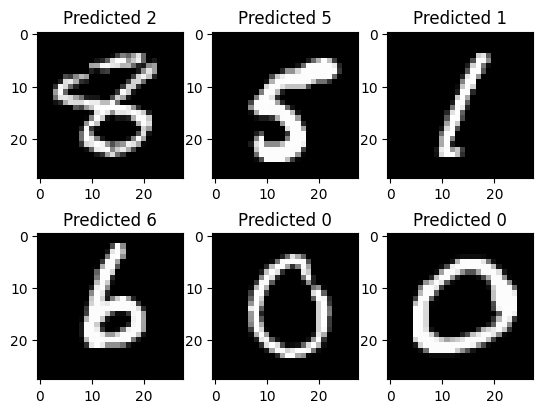

In [72]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [73]:

submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,27132,2
1,27701,5
2,1870,1
3,17230,6
4,26232,0
